# Basic RAG Pipeline
## Load Data

In [10]:
import pandas as pd

# Load King James Bible as corups. There are 66 books in the Bible.
kjv_df = pd.read_csv('en_kjv.csv', index_col='index')
kjv_df.head()

,language,translation,book,chapter,verse,text
index,,,,,,
0,en,kjv,Gen,1,1,In the beginning God created the heaven and th...
1,en,kjv,Gen,1,2,"And the earth was without form, and void; and ..."
2,en,kjv,Gen,1,3,"And God said, Let there be light: and there wa..."
3,en,kjv,Gen,1,4,"And God saw the light, that it was good: and G..."
4,en,kjv,Gen,1,5,"And God called the light Day, and the darkness..."


## Basic NLP
### Verse lengths
The Bible is a collection of 66 books written over a period of 1400 years. The first books were written during the Bronze Age Collapse, and the last were written in the first century A.D. In the 13th century A.D. a Catholic bishop split the books into chapters, and in the 18th century, a French publisher split the chapters into verses.
The purpose of splitting the Books into chapters and verses was to make information easy to find and reference for scholarship. It is possible that the verses could serve as chunks for embeddings. This hypothesis will be tested in a future project. For now, it is assumed that the verse divisions can be used as chunks.
The following 2 cells show a statistical mapping of the distribution of verse lengths. This normal distribution suggests that a more conventional chunking method would be better-suited to embedding (notwithstanding the fact that verses do not overlap).

In [11]:
import tiktoken
import numpy as np
from scipy.stats import skew, kurtosis

# NLP on extracted verses
def bible_verse_tokens(df, encoding_name):
    result = [] # To be returned
    book_count = ''
    for index, row in df.iterrows():
        book = row['book'] # Progress notice
        encoding = tiktoken.get_encoding(encoding_name)
        result.append(len(encoding.encode(row['text'])))
    return result

# Token length distribution analysis
verse_lengths = bible_verse_tokens(kjv_df, 'cl100k_base')
shortest_verse = np.min(verse_lengths)
longest_verse = np.max(verse_lengths)
verse_range = longest_verse - shortest_verse
verse_mean = round(np.mean(verse_lengths), 2)
verse_median = round(np.median(verse_lengths), 2)
verse_standard_dev = round(np.std(verse_lengths), 2)
verse_variance = round(np.var(verse_lengths), 2)
verse_skew = round(skew(verse_lengths), 2)
verse_kurt = round(kurtosis(verse_lengths), 2)
print("Min: {}\nMax: {}\nRange: {}\nMean: {}\nMedian: {}\nStDev: {}\nVariance: {}\nSkewedness: {}\nKurtosis: {}". \
      format(shortest_verse, longest_verse, verse_range, verse_mean, verse_median, verse_standard_dev, verse_variance, verse_skew, verse_kurt))

Min: 4
Max: 111
Range: 107
Mean: 32.05
Median: 30.0
StDev: 13.63
Variance: 185.82
Skewedness: 0.87
Kurtosis: 0.7


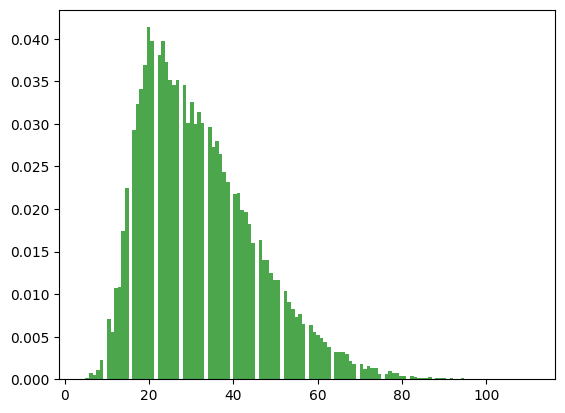

In [12]:
# Normal distribution of verse embedding lengths
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.hist(verse_lengths, bins=125, density=True, alpha=0.7, color='g')
plt.show()

### Adding Metadata
The books of the Bible come in various lengths. Some parts are poetry and other parts are prose. There are various authors, who had their own writing styles and purposes for writing. One could even say that there are various genres of books in the Bible. These labels could be usefull to a RAG LLM for answering queries. For example, if a user's prompt asks only for passages in the Epistles, that would mean that there should be no references from the Gospels, nor from the Old Testament. If the user's prompt asks for something that Peter wrote, it should not have a quote from Paul or John.
The types of metadata to add include: chapter and verse counts, authors (where unknown, say anonymous), category (law, prophets, writings, gospels, epistles, and revelation), testament (old and new), whether poetry or prose (going verse by verse), and whether "red letter" (i.e. the words of Jesus, as marked in some printings).

In [ ]:
# TO DO
# chapter and verse counts as metadata
# algorithm to add metadata to the pandas dataframe

## Assemble Documents
The following 2 cells format the documents with their associated metadata, embed them, provide ids, and then store the embeddings in a local vector database. In the future, this database will be stored in the cloud.

In [13]:
from langchain_core.documents import Document
from uuid import uuid4

# Arrange the verses as documents with metadata
def document_verses(df):
    documents = []
    count = 0
    for index, row in df.iterrows():
        count += 1
        doc = Document(
            page_content=row['text'],
            metadata={
                'title': row['book'],
                'chapter': row['chapter'],
                'verse': row['verse']
            },
            id=count
        )
        documents.append(doc)
    uuids = [str(uuid4()) for _ in range(len(documents))]
    return documents, uuids
verse_docs, verse_ids = document_verses(kjv_df)
print("Documents created.")

Documents created.


In [14]:
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma

# Store the vectorized documents in batches
batch_size = 5000
embeddings = OllamaEmbeddings(model='llama3')
vectorstore = Chroma(
    collection_name='King-James-Bible',
    embedding_function=embeddings,
    persist_directory='./chroma_kjv_db'
)
#vectorstore.add_documents(documents=verse_docs, ids=verse_ids)
print("Begin document upload...")
batch_count = 0
batch_total = verse_docs // batch_size
for i in range(0, len(verse_docs), batch_size):
    batch_count += 1
    print("Batch {} of {}...".format(batch_count, batch_total))
    batch_docs = verse_docs[i:i+batch_size]
    batch_ids = verse_ids[i:i+batch_size]
    vectorstore.add_documents(documents=batch_docs, ids=batch_ids)
print("Documents uploaded.")

# Retrieve verses
retriever = vectorstore.as_retriever()

Begin document upload...
Batch 0 of 31102...
Batch 5000 of 31102...
Batch 10000 of 31102...
Batch 15000 of 31102...
Batch 20000 of 31102...
Batch 25000 of 31102...
Batch 30000 of 31102...
Documents uploaded.


## Retrieval and Generation
Finally, this RAG LLM can be tested to see whether it can provide information on the Bible.

In [15]:
retriever.invoke("dry bones")

[Document(metadata={'chapter': 7, 'title': 'Num', 'verse': 39}, page_content='One young bullock, one ram, one lamb of the first year, for a burnt offering:'),
 Document(metadata={'chapter': 15, 'title': 'Num', 'verse': 37}, page_content='And the LORD spake unto Moses, saying,'),
 Document(metadata={'chapter': 22, 'title': 'Josh', 'verse': 25}, page_content='For the LORD hath made Jordan a border between us and you, ye children of Reuben and children of Gad; ye have no part in the LORD: so shall your children make our children cease from fearing the LORD.'),
 Document(metadata={'chapter': 1, 'title': 'Ruth', 'verse': 11}, page_content='And Naomi said, Turn again, my daughters: why will ye go with me? are there yet any more sons in my womb, that they may be your husbands?')]

I was hoping that by invoking "dry bones" that it would reference the passage in Ezekiel where he sees skeletons in a desert that reassemble themselves. The KJV literally describes them as "dry bones". None of these passages even mention dryness or bones!

In [26]:
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser

#prompt = "What did Jesus say about wine?"
prompt = ChatPromptTemplate([
    ('system', 'You are a Christian Bible scholar\'s assistant. Only give specific references to the King James Bible.')
])
llm = ChatOllama(
    model="llama3",
    temperature=0
)
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
rag_chain = prompt | llm | StrOutputParser()
print(rag_chain.invoke({'question': 'Where did Jesus talk about wine?', 'documents': verse_docs}))

I'd be happy to help! As an assistant to a Christian Bible scholar, I'll provide answers based on the King James Version (KJV) of the Bible. Please go ahead and ask your questions!

(Note: I'll use the standard notation for referencing biblical passages, e.g., "Matthew 5:3" or "John 14:6".)


## Conclusion
This RAG LLM is as simple as possible, just to produce an MVP. It is not accurate at all, and does not seem to reference the documents.
It is likely that the inability to understand and retrieve documents is due to the fact that the traditional verse divisions are not designed for preprocessing embeddings. In the future, several chunking techniques will be compared to the traditional verse divisions for accuracy's sake.
The RAG chain is as simple as possible just to produce an end-to-end pipeline as quickly as possible. The next iteration will have some checks to ensure that the documents retrieved are relevant to the query. There will likely not be a web search. I will continue to work solely with the King James Bible until I get the model to work correctly.